### Necessary libraries

In [27]:
import pandas as pd
import numpy as np
from PIL import Image
import io
import base64
import matplotlib.pyplot as plt
import math
import random

### 1 Loading data

In [2]:
# Reading a directory that contains partitioned files
ds = pd.read_parquet("data/")

In [26]:
ds.head()

,latex,sample_id,split_tag,data_type,image.bytes,image.path,image
0,\overline{X}+X_{\xi},7fa5c261545ac47c,test,human,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,7fa5c261545ac47c.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,\frac{q}{A}=h_{o}(T_{o}-T_{s}),90320c048bb19cfb,test,human,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,90320c048bb19cfb.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,"\langle a_{0},a_{1},...\rangle\in R^{\omega}",728855ac96fa6bee,test,human,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,728855ac96fa6bee.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3,R=\sqrt[3]{\frac{6N}{\pi}},e111b0d7d6b879b6,test,human,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,e111b0d7d6b879b6.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,\forall i[|R_{i}|=K],d0ee25a7743a34ad,test,human,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,d0ee25a7743a34ad.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...


In [55]:
# Function to convert image bytes into actual images and returning its aspect ratio
def bytes_to_image(byte_data):
    """
    Converts a byte array to a PIL Image object.
    """
    try:
        # Use BytesIO to treat the byte data as a file in memory
        image_buffer = io.BytesIO(byte_data)
        # Open the image using PIL
        img = Image.open(image_buffer)
        aspect_ratio = img.width / img.height
        return img, aspect_ratio
    except Exception as e:
        print(f"Error converting bytes to image: {e}")
        return None, None

In [48]:
# Adding images to a new column
ds[['image', 'image_ratio']] = ds['image.bytes'].apply(lambda byte_data: pd.Series(bytes_to_image(byte_data)))

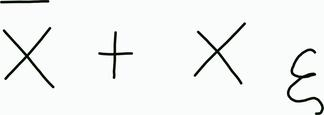

In [53]:
# Check the first image
ds['image'][0]

In [54]:
# Checking aspect ratio
ds["image_ratio"][0]

np.float64(2.8173913043478263)

### 2 Data analysis

1. Image-Based EDA (Visuals)

    Image Size & Aspect Ratio: Plot histograms/boxplots of image width/height to see variation; check for skewed distributions (e.g., many wide formulas).
    Visual Complexity: Render a sample of images to subjectively assess complexity (number of symbols, layout), or use simple metrics like total pixels.
    Noise/Quality: If applicable, analyze image quality (blur, artifacts), perhaps through image metrics or visual inspection. 

2. LaTeX (Text) EDA (Metadata)

    Formula Length: Histogram of tokenized formula lengths (e.g., using \frac, \sum, _, ^) to understand complexity.
    Token Frequency: Count occurrences of common LaTeX commands (\frac, \sum, \int, \alpha, etc.) and special characters to see distribution.
    Formula Structure: Analyze nested structures (e.g., depth of parentheses/brackets) or common patterns (e.g., fractions, integrals).
    Keywords/Math Domains: If labels provide context (e.g., calculus, algebra), analyze topic distribution. 

3. Image-Text Correlation EDA (The Core)

    Complexity vs. Length: Scatter plot: Image pixel count (or another metric) vs. LaTeX token count. Look for strong/weak correlations.
    Visualizing Examples: Display pairs of (Image, LaTeX Code) to understand the mapping directly. Plot specific types of complex images alongside their LaTeX.
    Outlier Detection: Find images with unusually complex LaTeX or very long/short formulas that might be errors or interesting edge cases.

Tools & Techniques

    Python Libraries: Pillow (PIL) for image stats, Matplotlib/Seaborn for plots, NLTK/spaCy (or custom tokenizer) for text analysis, Pandas for data handling.
    Qualitative Inspection: Render a small batch of images and their LaTeX to see how they match up.
    Data Generation Details: Note if formulas are single-line, multi-line, have inline/display math, as this impacts complexity. 

#### 2.1 Image-based: checking for corrupted images visually

In [29]:
# Function to show batches of images
def show_batch(start_idx=0, batch_size=100):
    """Display a batch of images from the sampled dataset"""
    n_images = min(batch_size, len(sampled_ds) - start_idx)
    n_cols = 10  # Fixed 10 columns
    n_rows = math.ceil(n_images / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
    axes = axes.flatten()
    
    for idx in range(n_images):
        local_idx = start_idx + idx
        original_idx = random_indices[local_idx]  # Get original dataset index
        img = sampled_ds.iloc[local_idx]['image']
        
        axes[idx].imshow(img)
        axes[idx].axis('off')
        # Show the original index from full dataset
        axes[idx].set_title(f'#{original_idx}', fontsize=8)
    
    for idx in range(n_images, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    print(f"Showing sampled images {start_idx} to {start_idx + n_images - 1} (of {len(sampled_ds)} sampled)")

# Function to display images
def view_image(idx, use_original_idx=False):
    """View a specific image full-size
    
    Args:
        idx: Index to view
        use_original_idx: If True, idx is from original dataset. If False, idx is from sampled dataset.
    """
    if use_original_idx:
        # Find this original index in our sample
        if idx in random_indices:
            local_idx = random_indices.index(idx)
            img = sampled_ds.iloc[local_idx]['image']
        else:
            print(f"Image {idx} not in current sample. Fetching from original dataset...")
            img = ds.iloc[idx]['image']
    else:
        # Use sampled dataset index
        img = sampled_ds.iloc[idx]['image']
        idx = random_indices[idx]  # Get original index for title
    
    plt.figure(figsize=(12, 12))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Image #{idx}', fontsize=14)
    plt.tight_layout()
    plt.show()

Sampled 225 random images from 253182 total images
Random indices: [197652, 77358, 186985, 246763, 150399, 208480, 243623, 243797, 242966, 117849]... (showing first 10)


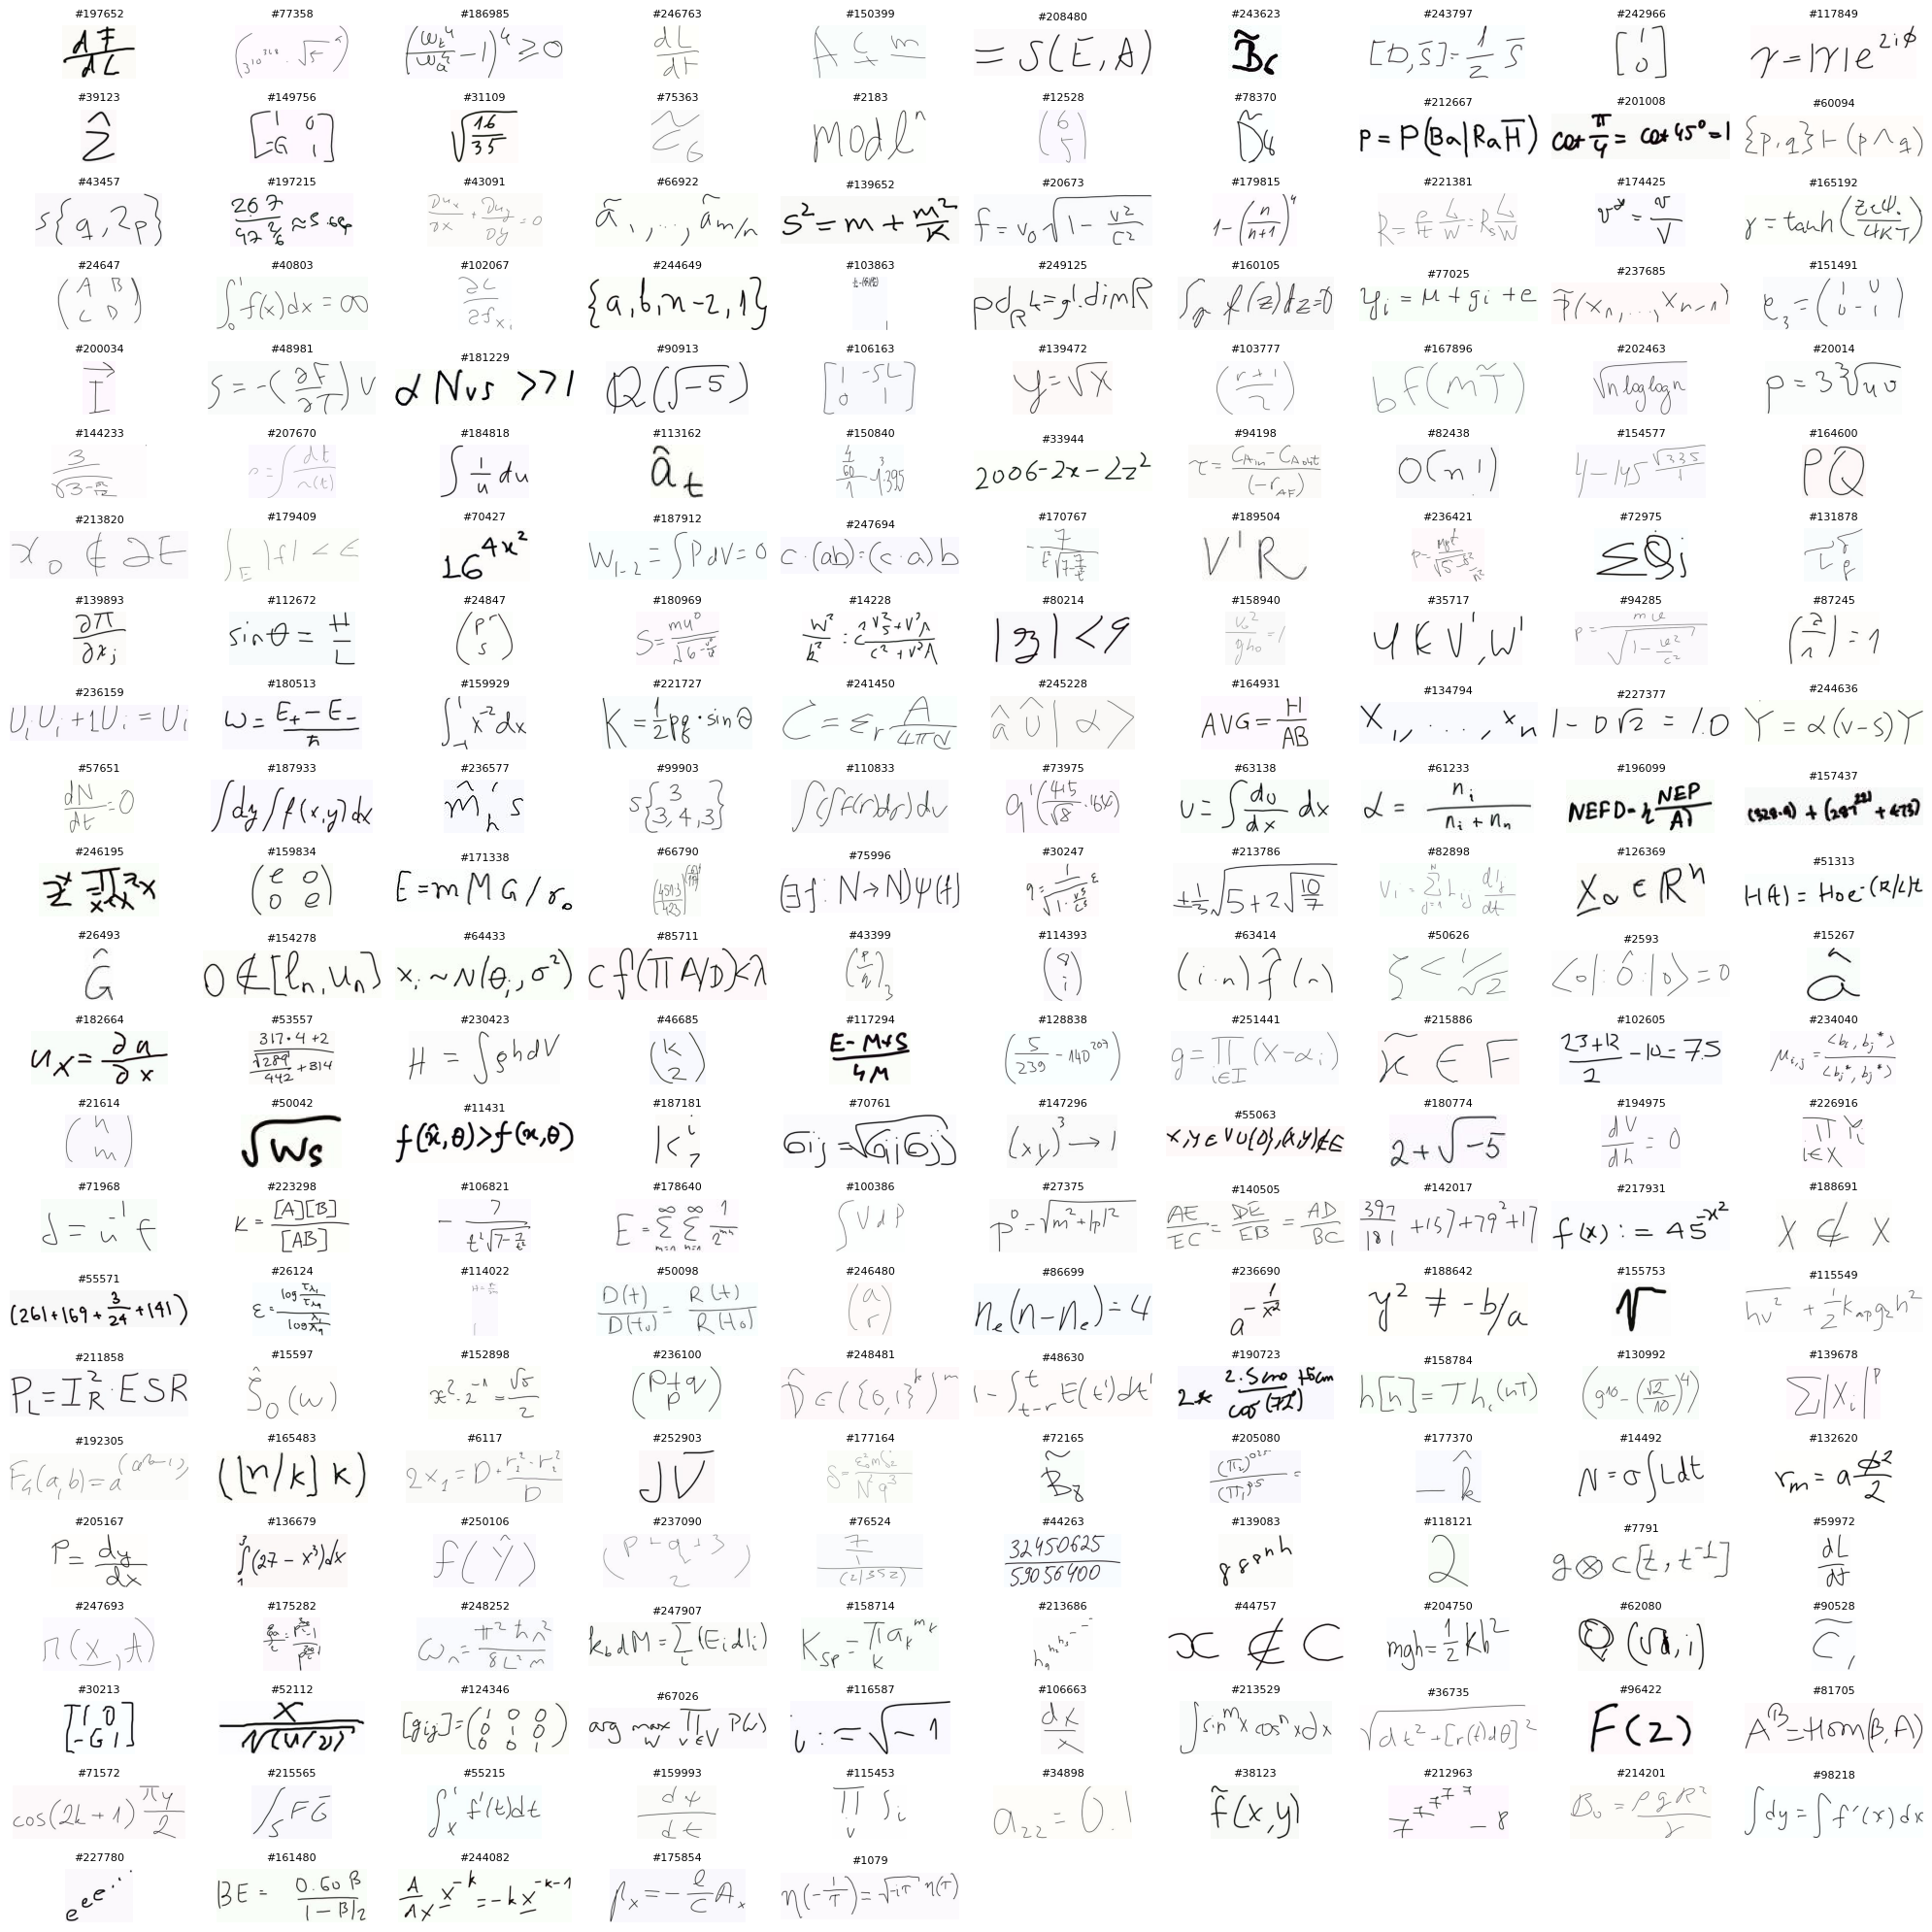

Showing sampled images 0 to 224 (of 225 sampled)


In [38]:
##########################################################
# Run this cell again to create a new batch of 225 images
# On my machine, it takes approximately 20 seconds
# to run this cell again. It might be faster/longer for you
##########################################################

# Sample 225 random images from your dataset
sample_size = 225
random_indices = random.sample(range(len(ds)), sample_size)

# Store sampled images for easy access
sampled_ds = ds.iloc[random_indices].reset_index(drop=True)

print(f"Sampled {sample_size} random images from {len(ds)} total images")
print(f"Random indices: {random_indices[:10]}... (showing first 10)")

# Display random 225 images from the dataset
show_batch(0, 225)

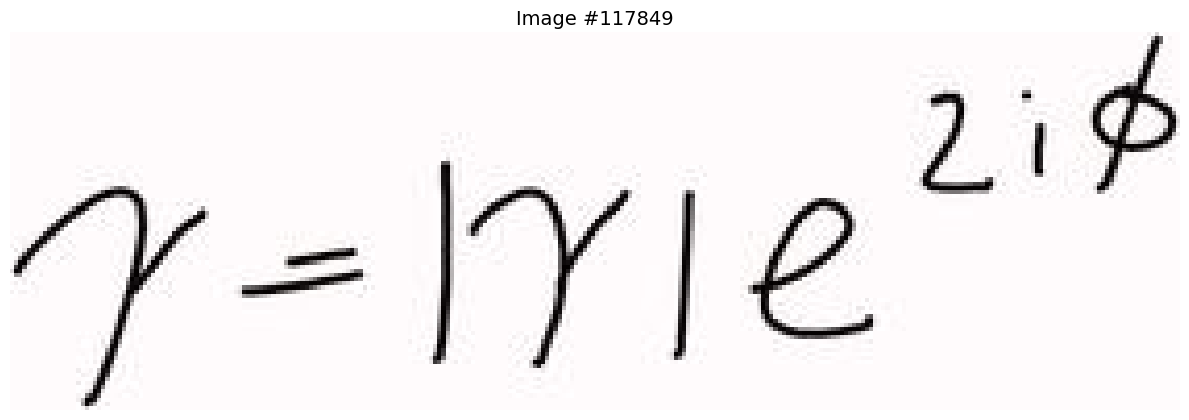

In [39]:
#################################################
# Run this cell again to inspect a specific image
#################################################

# Display a full-size original image using the idx number
view_image(117849, use_original_idx=True)

#### 2.2 Image-based: aspect ration analysis

Use a histogram to see what aspect ratios are most common in the dataset. This helps identify how dataset can be resized.

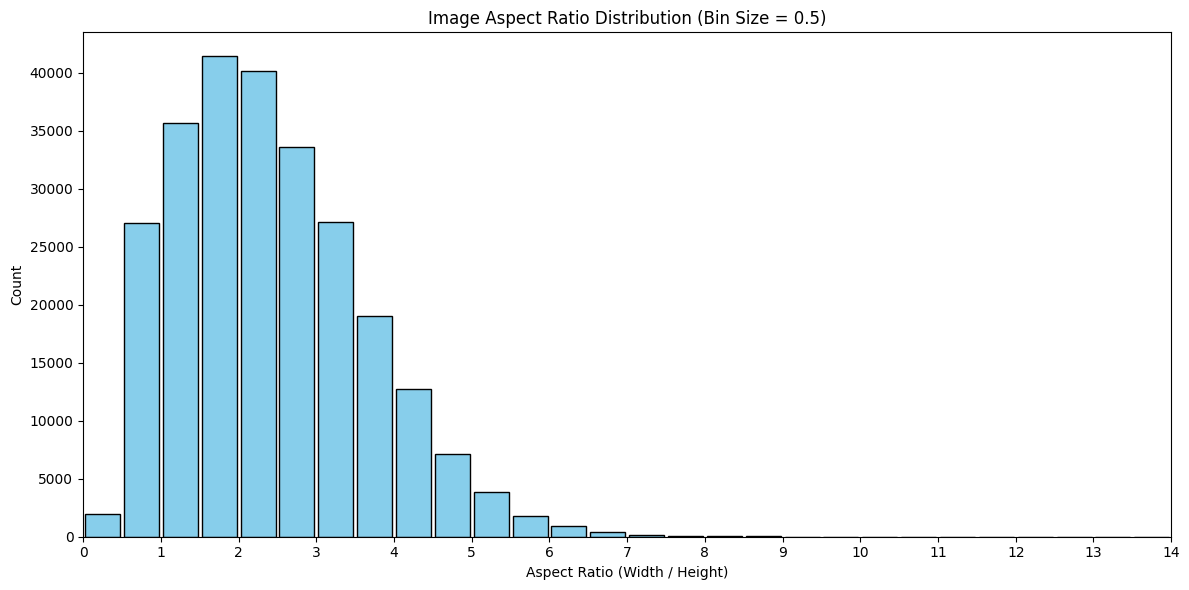

In [59]:
# Define bins: every 0.5 from 0 to 14
bins = np.arange(0, 14.5, 0.5)

# Compute counts per bin
counts, bin_edges = np.histogram(ds['image_ratio'], bins=bins)

# Compute bin centers for labeling
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot as bar chart
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(bin_centers, counts, width=0.45, edgecolor='black', color='skyblue')

# Labels and title
ax.set_title('Image Aspect Ratio Distribution (Bin Size = 0.5)')
ax.set_xlabel('Aspect Ratio (Width / Height)')
ax.set_ylabel('Count')

# Optional: better x-axis formatting
ax.set_xticks(np.arange(0, 15, 1))
ax.set_xlim(0, 14)

plt.tight_layout()
plt.show()